In [1]:
import os
import pickle # for files handling
import numpy as np
from tqdm.notebook import tqdm # ui of processing progress
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import re
import tensorflow as tf
from nltk.translate.bleu_score import corpus_bleu

In [2]:
BASE_DIR = "/kaggle/input/flickr8k"
WORKING_DIR = "/kaggle/working/"

## Extract image features

In [3]:
# load vgg16 model
model = VGG16()
# model.layers[-2] this is the last fully connexted layer for the model
# restructure the model
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
# summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
# extract features from images
features = {}
directory = os.path.join(BASE_DIR, 'Images')
for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = directory + "/" + img_name
    image = load_img(img_path, target_size = (224, 224)) #resizing the image
    # convert image pixels to numpy array
    image = img_to_array(image)
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2])) # 1 mean tha batch size-->one image in each batch
    #preprocess image for vgg
    image = preprocess_input(image)
    # extract features
    feature = model.predict(image, verbose=0)
    # get image Id
    image_id = img_name.split('.')[0]
    # store features
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
# store features in pickle 
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## load the captions data

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f) # because in f we found that the first line is (image, caption)
    captions_doc = f.read()

In [8]:
# print(captions_doc)

In [9]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split("\n")):
    # split the line by ,
    tokens = line.split(',')
    if len(line)<2:
        continue
    image_id, caption = tokens[0], tokens[1]
    # removing extension from image_id
    image_id = image_id.split(".")[0]
    # convert caption list to string
    caption = "".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
        # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
print(len(mapping))

8091


## preprocess text data

In [11]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            caption = caption.lower() # convert to lower case
            caption = re.sub(r'[^A-Za-z ]', '', caption) # delete everything that is not a letter
            caption = caption.replace('\s+',' ') # replace multiple spaces with one single space
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(caption) > 1]) + ' endseq'
            captions[i] = caption

In [12]:
# before preprocess of text
mapping["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
# preprocess the text
clean(mapping)

In [14]:
# after preprocessing
mapping["1000268201_693b08cb0e"]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq']

In [15]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [16]:
len(all_captions)

40455

In [17]:
 all_captions[:10]

['startseq a child in a pink dress is climbing up a set of stairs in an entry way endseq',
 'startseq a girl going into a wooden building endseq',
 'startseq a little girl climbing into a wooden playhouse endseq',
 'startseq a little girl climbing the stairs to her playhouse endseq',
 'startseq a little girl in a pink dress going into a wooden cabin endseq',
 'startseq a black dog and a spotted dog are fighting endseq',
 'startseq a black dog and a tricolored dog playing with each other on the road endseq',
 'startseq a black dog and a white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [18]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [19]:
vocab_size

8588

In [20]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)

In [21]:
max_length

35

## train test split

In [22]:
image_ids = list(mapping.keys())
split = int(len(image_ids)*0.90)
split

7281

In [23]:
train = image_ids[:split]
test = image_ids[split:]

In [24]:
len(train) + len(test) - len(image_ids)

0

In [25]:
def create_tf_dataset(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    def generator_function():
        for key in data_keys:
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # Right pad the sequence (important for cuDNN compatibility)
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    yield (features[key][0], in_seq), out_seq
    
    # Define output shapes and types
    output_types = ((tf.float32, tf.int32), tf.float32)
    output_shapes = ((tf.TensorShape([4096]), tf.TensorShape([max_length])), 
                     tf.TensorShape([vocab_size]))
    
    # Create dataset from generator
    dataset = tf.data.Dataset.from_generator(
        generator_function,
        output_types=output_types,
        output_shapes=output_shapes
    )
    
    # Batch and prefetch for performance
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## model creation

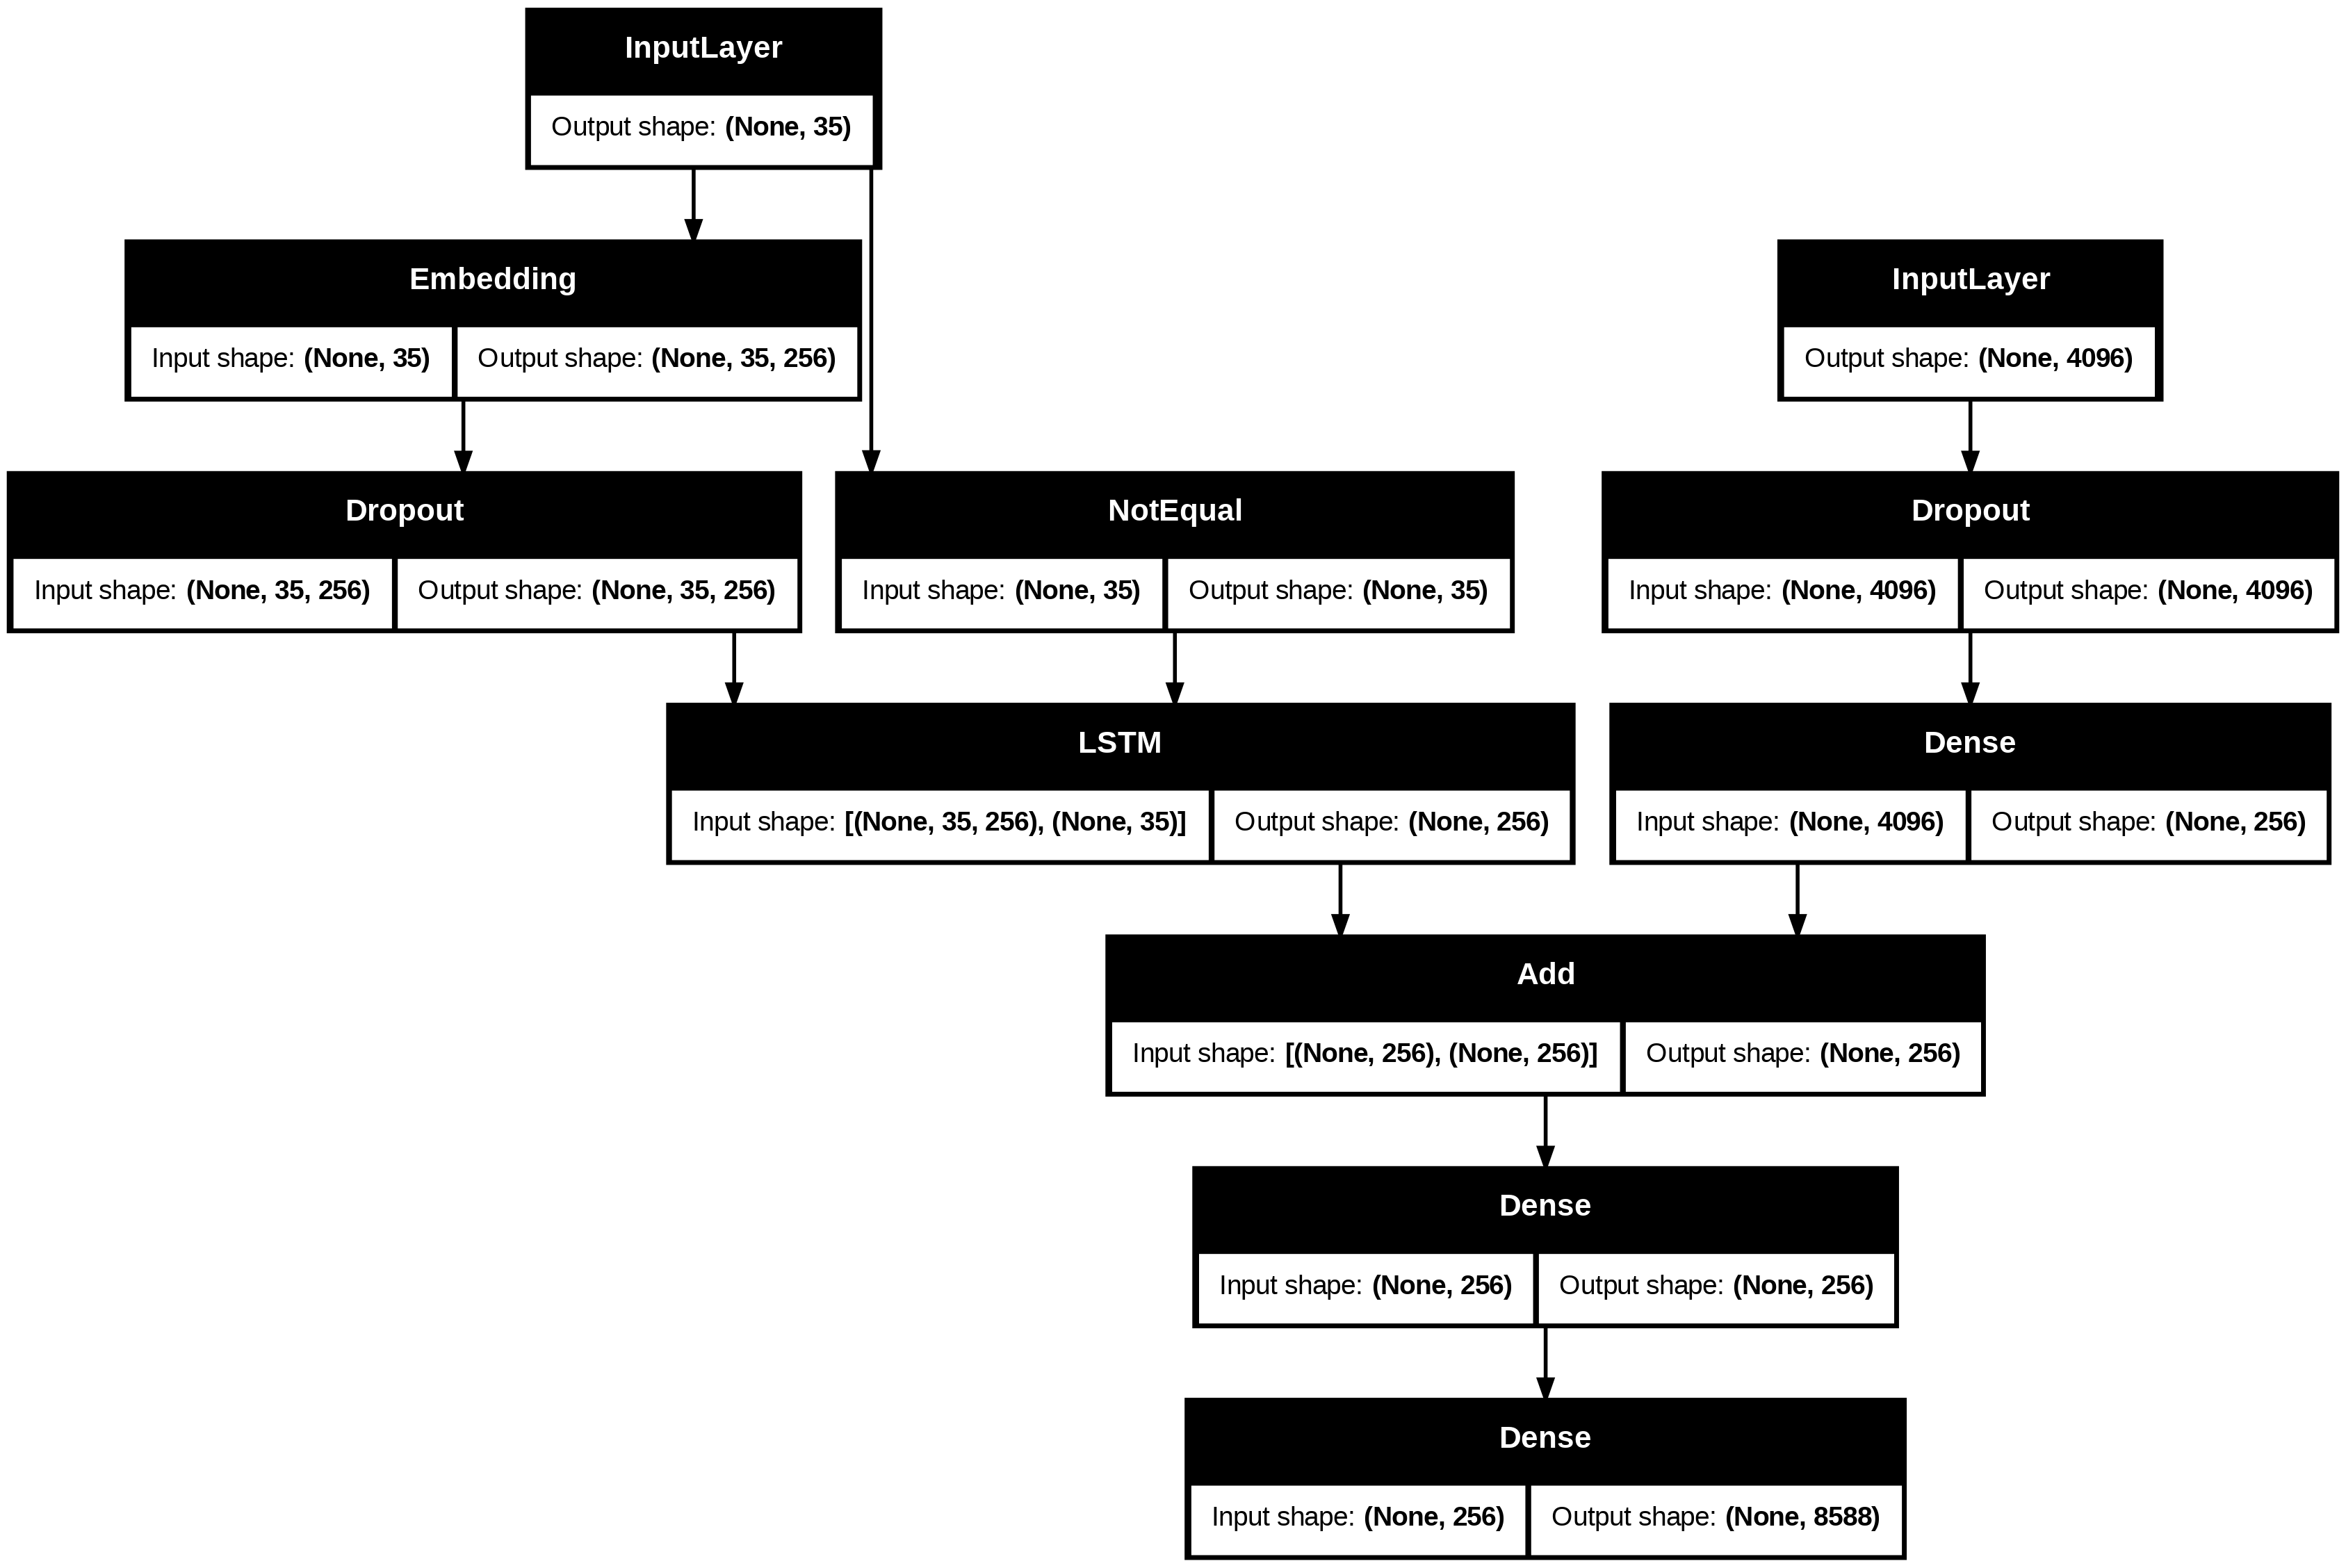

In [26]:
def create_model(vocab_size, max_length):
    # image feature layers
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.4)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    
    # sequence feature layers
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.4)(se1)
    
    # Configure LSTM to be compatible with cuDNN
    se3 = LSTM(256, implementation=1, recurrent_activation='sigmoid', 
               unroll=False, use_bias=True)(se2)
    
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation="relu")(decoder1)
    outputs = Dense(vocab_size, activation="softmax")(decoder2)
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss="categorical_crossentropy", optimizer="adam")
    return model

# Create the model
model = create_model(vocab_size, max_length)
plot_model(model, show_shapes=True)

In [27]:
# Create the dataset
batch_size = 64
train_dataset = create_tf_dataset(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Train the model
epochs = 20
model.fit(train_dataset, epochs=epochs, verbose=1)

Epoch 1/20
6452/6452 ━━━━━━━━━━━━━━━━━━━━ 161s 24ms/step - loss: 4.4263
Epoch 2/20
   5/6452 ━━━━━━━━━━━━━━━━━━━━ 2:45 26ms/step - loss: 3.1379

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


6452/6452 ━━━━━━━━━━━━━━━━━━━━ 158s 24ms/step - loss: 3.3415
Epoch 3/20
6452/6452 ━━━━━━━━━━━━━━━━━━━━ 157s 24ms/step - loss: 3.0931
Epoch 4/20
6452/6452 ━━━━━━━━━━━━━━━━━━━━ 159s 25ms/step - loss: 2.9555
Epoch 5/20
6452/6452 ━━━━━━━━━━━━━━━━━━━━ 157s 24ms/step - loss: 2.8558
Epoch 6/20
6452/6452 ━━━━━━━━━━━━━━━━━━━━ 157s 24ms/step - loss: 2.7860
Epoch 7/20
6452/6452 ━━━━━━━━━━━━━━━━━━━━ 157s 24ms/step - loss: 2.7545
Epoch 8/20
6452/6452 ━━━━━━━━━━━━━━━━━━━━ 158s 24ms/step - loss: 2.7091
Epoch 9/20
6452/6452 ━━━━━━━━━━━━━━━━━━━━ 157s 24ms/step - loss: 2.6736
Epoch 10/20
6452/6452 ━━━━━━━━━━━━━━━━━━━━ 159s 25ms/step - loss: 2.6478
Epoch 11/20
6452/6452 ━━━━━━━━━━━━━━━━━━━━ 157s 24ms/step - loss: 2.6270
Epoch 12/20
6452/6452 ━━━━━━━━━━━━━━━━━━━━ 158s 25ms/step - loss: 2.7368
Epoch 13/20
6452/6452 ━━━━━━━━━━━━━━━━━━━━ 158s 24ms/step - loss: 2.6249
Epoch 14/20
6452/6452 ━━━━━━━━━━━━━━━━━━━━ 157s 24ms/step - loss: 2.6006
Epoch 15/20
6452/6452 ━━━━━━━━━━━━━━━━━━━━ 157s 24ms/step - loss: 2.62

In [28]:
model.save(WORKING_DIR+"/best_model.h5")

## Generate captions for the image

In [29]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None  # Fixed the indentation - this was causing all words except the first to return Non

In [30]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag
    in_text = 'startseq'
    # iterate over the max length
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence with post padding (right padding) to match training
        sequence = pad_sequences([sequence], maxlen=max_length, padding='post')
        # reshape image for prediction
        image_reshaped = np.array([image[0]])  # Ensure image is properly formatted as batch
        # predict the next word
        yhat = model.predict([image_reshaped, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == "endseq":
            break
    return in_text

In [31]:
# validate with text data
actual, predicted = list(), list()
for key in tqdm(test):
    # get actual captions for this image
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # prepare actual captions for comparison
    actual_captions = [caption.split() for caption in captions]
    actual.append(actual_captions)
    predicted.append(y_pred.split())
    
# calculate bleu score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.528260
BLEU-2: 0.325538


## visualize the results

----------- actual ----------
startseq a black and white dog drinking water from a water spray endseq
startseq a black and white dog is being soaked with a jet of water in a blue paddling pool endseq
startseq a dog sticking its face into the shower from a garden hose endseq
startseq a small white dog gets sprayed by water endseq
startseq a white and black dog is jumping into a pool endseq
--------- prediction --------
startseq a dog is running through a field of grass endseq


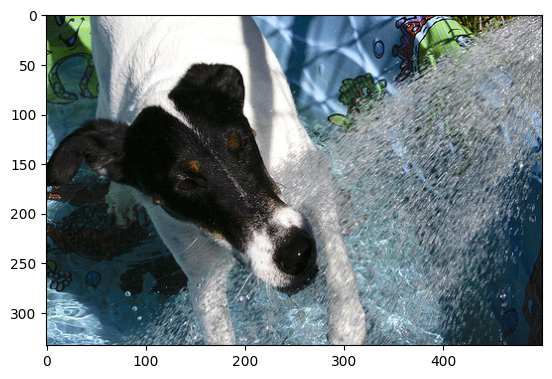

In [32]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split(".")[0]
    image_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(image_path)
    captions = mapping[image_id]
    print("----------- actual ----------")
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print("--------- prediction --------")
    print(y_pred)
    plt.imshow(image)
image_name = "1096097967_ac305887b4.jpg"
generate_caption(image_name)